<a href="https://colab.research.google.com/github/Nayal17/Vanilla-Neural-Networks/blob/main/Vanilla_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import random
import numpy as np 
import matplotlib.pyplot as plt

In a neural network we have a very important step called backpropagation which updates the weights to improve the model performance. For that we calculates how a weight effects the loss by finding gradients and constantly improving it.  
***Below is the basic understanding of gradient calculation.***


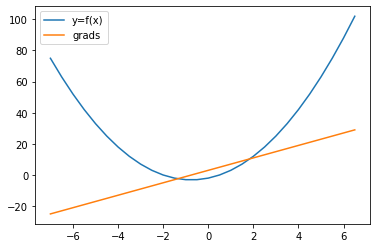

In [3]:
def fox(x):
  return 2*x*x + 3*x - 2

def calculate_grad(x):
  """
  Example: y=2x^2 + 3*x - 2 at x=4 
  grad(dy/dx) = 4 = 4*x + 3 = 4*4 + 3 = 19 
  """
  h = 0.0000001 # here h->0
  return (fox(x+h)-fox(x))/h
    

x = np.arange(-7,7,0.5)
y = fox(x)
grads = [calculate_grad(x_) for x_ in x]
plt.plot(x, y, label="y=f(x)")
plt.plot(x, grads, label="grads")
plt.legend()
plt.show()

If y depends on x and x depends on z then we can calculte grads in the same way using chain rule, which implies:

***dy/dz = dy/dx * dx/dz***

Making a class which can calculate gradients on it's own.

In [30]:
class Value:
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self.grad = 0.0
    self.prev = set(children) # keeping track of previous operands
    self.op =  op # keeping track of previous operation
    self.label = label
    self._backward = lambda : None

  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other) # to enable the operation of Value object and an integer too. e.g., Value(1) + 1 = Value(data=(2))
    out = Value(self.data + other.data, (self, other), op='+')
    
    def _backward():
      # grad = local_grad * prev_grad
      self.grad += 1.0 * out.grad # '+=' accumulate the gradient if a variable is used twice and gradients are also calculated twice 
      other.grad += 1.0 * out.grad 
    out._backward = _backward

    return out

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), op='*')

    def _backward():
      self.grad += other.data * out.grad 
      other.grad += self.data * out.grad
    out._backward = _backward
    
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), op="**")

    def _backward():
      self.grad += other * (self.data ** (other -1)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), op='exp')

    def _backward():
      self.grad += out.data + out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), op='tanh')

    def _backward():
      self.grad += (1-t**2) * out.grad # d(tanh(x))/ds = d(tanh(x))/dx * dx/ds (chain rule)
    out._backward = _backward

    return out

  def relu(self): 
    out = Value(0 if self.data < 0 else self.data, (self,), op='relu')

    def _backward():
      self.grad += (self.data > 0) * out.grad
    out._backward = _backward

    return out 

  def return_nodes(self):
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node.prev:
          build_topo(child)
        topo.append(node)
    build_topo(self)
    return topo

  def backward(self):
    nodes = self.return_nodes()
    self.grad = 1.0
    for node in reversed(nodes):
      node._backward()

  def zero_grad(self):
    nodes = self.return_nodes()
    
    for node in reversed(nodes):
      node.grad = 0.0

  def __neg__(self):
    return self * -1

  def __sub__(self,other):
    return self + (-other)

  def __rsub__(self, other): 
    return other + (-self)

  def __radd__(self,other): 
    return self + other

  def __rmul__(self,other): 
    return self * other

  def __truediv__(self,other):
    return self * (other**-1)

  def __rtruediv__(self, other): 
    return other + (self**-1)

  def __repr__(self):
    return f"Value(data={self.data})"

In [31]:
a = Value(2,label='a') 
b = Value(3,label='b') 
c = a * b
c.label = 'c'
d = Value(4,label='d') 
e = c + d
e.label = 'e'
f = Value(5,label='f')
g = e * f
g.label='g' 

print(f.prev)
print("op:",f.op)

set()
op: 


In [32]:
from graphviz import Digraph

def trace(root):
  """build set of all nodes and edges in the graph"""
  nodes, edges = set(), set()

  def build(node): 
    if node not in nodes:
      nodes.add(node)
      for child in node.prev:
        edges.add((child, node))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad,), shape="record")
    if n.op:
      dot.node(name=uid+n.op, label=n.op)
      dot.edge(uid+n.op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot


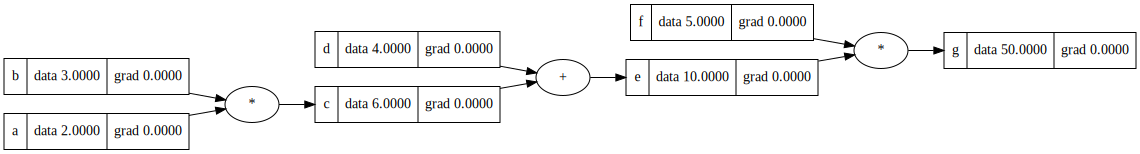

In [33]:
draw_dot(g)

1) **dg/dg** = 1

2) **d(e x f)/de** = f and **d(e x f)/df** = e

3) **dg/dc** = dg/de x de/dc = f x d(c+d)/dc = f x 1 and **dg/dd** = f x 1

4) **dg/db** = dg/dc x dc/db = (f x 1) x d(b x a)/db = f x 2 and **dg/da** = dg/dc x dc/da = (f x 1) x d(b x a)/da = f x 3 


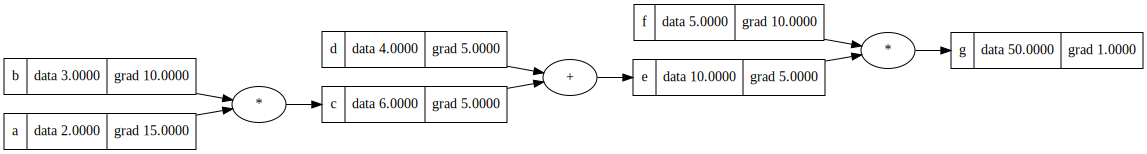

In [36]:
# filling grad values by calculating it manually
def set_grad_manually():
  g.grad = 1.0
  e.grad = 5.0
  f.grad = 10.0
  c.grad = 5.0
  d.grad = 5.0
  b.grad = 10.0
  a.grad = 15.0

set_grad_manually()
draw_dot(g)

***From above observation we get to know that:***
> multiplication(a * b): Previous grad * other.data

> addition(a + b): Previous grad * 1

Now using backward function of Value class to calculate all gradients automatically.

Reset Grad


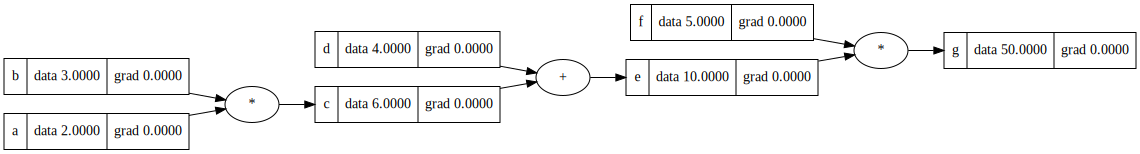

Calculate grad with backward method


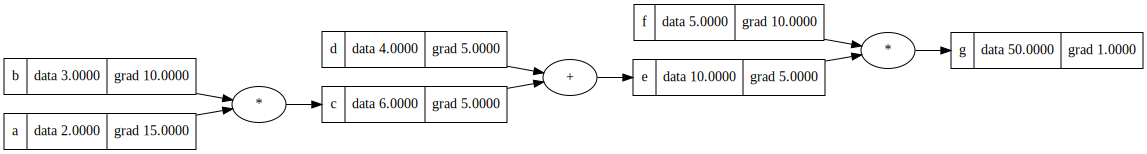

In [35]:
g.zero_grad() # first let's reset grad which are manually filled.
print("Reset Grad")
display(draw_dot(g))
print("Calculate grad with backward method")
g.backward()
display(draw_dot(g))

# A Neuron
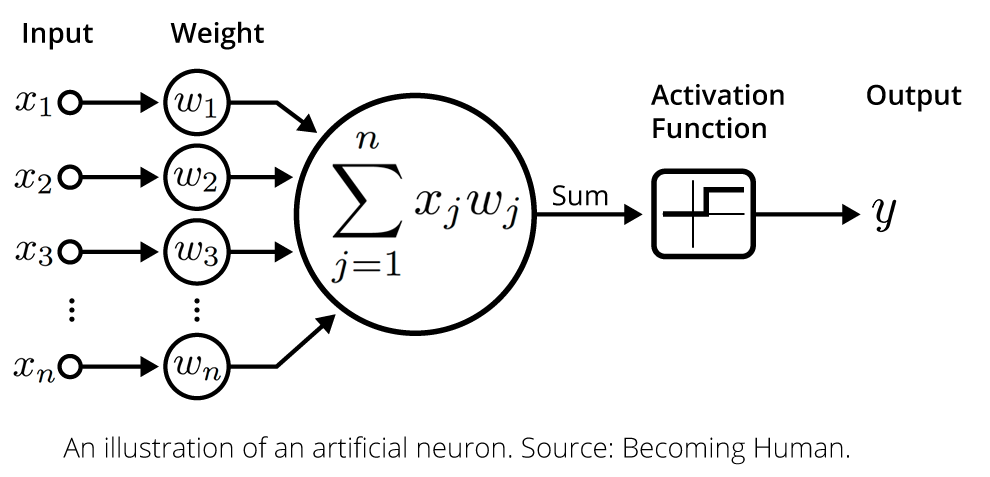

In [37]:
class Neuron:
  def __init__(self, num_inputs):
    self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    out = sum((wi*xi for wi, xi in zip(self.w, x)), start=b) # wixi + b
    return out.tanh()

  def parameters(self):
    return self.w + [self.b]

# Layers of Neuron
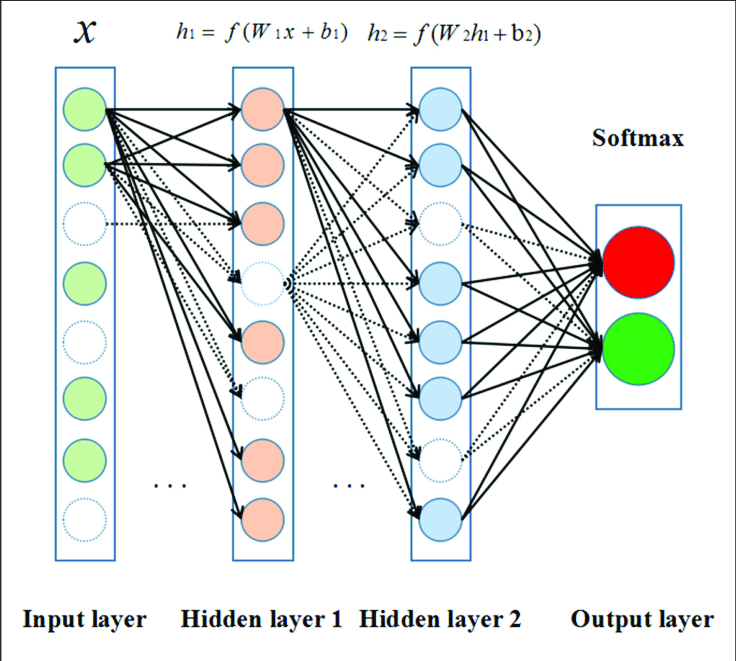

In [41]:
class Layer:
  """
  Num of inputs is the number of features(like, height, weight, bmi etc) for the first layer and
  for further layers it is same as num of neurons in the previous layer as every neuron in the previous layer gives an input to every neuron in the current layer.
  """
  def __init__(self, num_inputs, num_neurons):
    self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]

  def __call__(self, x):
    out = [n(x) for n in self.neurons]
    out = out[0] if len(out)==1 else out
    return out

  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]


class MLP: 
  """
  args:
  num_inputs => number of inputs for the network that is number of inputs to the first layer
  layer_sizes => number of neurons in each and every layer, different layers may have different number of neurons. Hence it is a list.
  """
  def __init__(self, num_inputs, layer_sizes):
    self.sizes = [num_inputs] + layer_sizes
    self.layers = [Layer(self.sizes[s], self.sizes[s+1]) for s in range(len(layer_sizes))]

  def __call__(self, x):
    for i, layer in enumerate(self.layers):
      x = layer(x)
    return x

  def parameters(self):
    return [p for l in self.layers for p in l.parameters()]

  def zero_grad(self):
    for l in self.layers:
      for p in l.parameters():
        p.zero_grad()


In [42]:
nn = MLP(2, [3, 4, 1])
x = [Value(1), Value(-2)]
print(nn(x))

Value(data=0.9973009884308794)


# Let's train this MLP on a toy data.

In [44]:
def loss_fn(preds, targets):
   return sum([(t - p)**2 for t, p in zip(targets, preds)])

inputs = [[1, -1, 5],
          [4, 2, 1],
          [1, -2, 3] ,
          [2, 3, 2] ]

targets = [-1 , 1, -1, 1]

nn = MLP(3, [4, 4 , 1])

preds = [nn(i) for i in inputs]
len(nn.parameters())

41

In [45]:
lr = 0.1
steps = 40

for step in range(steps):
  preds = [nn(i) for i in inputs]
  loss = loss_fn(preds, targets)
  
  if step%2==0:
    print(loss)
  
  ## zero grad
  nn.zero_grad()

  ## update grad
  loss.backward()
  for p in nn.parameters():
    p.data -= lr * p.grad


Value(data=7.964860040569552)
Value(data=7.960734182921682)
Value(data=7.955536442765409)
Value(data=7.948795947367121)
Value(data=7.939724559003299)
Value(data=7.926901654884176)
Value(data=7.9075002275646185)
Value(data=7.875055781947881)
Value(data=7.811331335202966)
Value(data=7.6428913489577806)
Value(data=6.766109680623304)
Value(data=5.122484436679125)
Value(data=5.092702525339872)
Value(data=5.042860252063376)
Value(data=4.907444995261977)
Value(data=4.323062420906778)
Value(data=1.685158523272658)
Value(data=0.09687432120322415)
Value(data=0.07670396485142014)
Value(data=0.06361810030203968)


In [46]:
preds

[Value(data=-0.8808257930583514),
 Value(data=0.8783056496737592),
 Value(data=-0.8780188064750822),
 Value(data=0.8787148151036008)]

***Credit: [Andrej Karpathy (MicroGrad)](https://github.com/karpathy/micrograd)***